In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, CP_L3_sparse_1, CP_L3_sparse_outer

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_outer, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

#from Cuda import DeviceDataLoader

In [2]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [3]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 6
IMAGE_CHANNELS = 1
RANK = 200
H_DIM = 200 

In [4]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [5]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [6]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
#train_loader = DeviceDataLoader(train_loader, device)
#val_loader = DataLoader(val_ds, BATCH_SIZE)

In [7]:
model = VAE_CP_L3_sparse_outer(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#model = DeviceDataLoader(model, device)


In [8]:
for images, _ in train_loader:
    recon_images, mu, logvar = model(images)
    break

In [9]:
torch.min(recon_images)

tensor(0.0005, grad_fn=<MinBackward1>)

In [10]:
i = images[8]

In [11]:
h1 = model.encoder(i)
z, mu, logvar = model.bottleneck(h1.to(device))
h2 = model.fc3(z)
recon = model.decoder(h2)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 200])

In [ ]:
dec_out = torch.matmul(h2, model.decoder.layer_C.weight.T)
torch.min(dec_out)


tensor(-6.9130e+24, grad_fn=<MinBackward1>)

In [ ]:
torch.sigmoid(dec_out)

tensor([[0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
         1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
         1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
         0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
         0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
         1., 0., 1., 0., 0.,

In [ ]:
out = model.decoder(torch.randn(200))

In [8]:
list_of_losses = []
list_of_epochs =[]
for epoch in range(NUM_EPOCHS):
    for images, _ in train_loader: 
        
        images = images.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)   
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images.to(device), images.to(device), mu.to(device), logvar.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                #epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)
    #list_of_losses.append(loss[0])
    #list_of_epochs.append(epoch)
    print('loss', loss)
    print("Epoch : ", epoch)

/home/ashish/Softwares/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss tensor(9215.3555, grad_fn=<AddBackward0>)
Epoch :  0


KeyboardInterrupt: 

In [ ]:
U3 = model.decoder[0].layer_U3.clone()

In [ ]:
U1_encoder = torch.tensor(model.encoder.l)

In [ ]:
model.encoder.layer_U1

In [9]:
for images, _ in train_loader: 
    recon_images, mu, logvar = model(images.to(device))
    break

In [10]:
recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

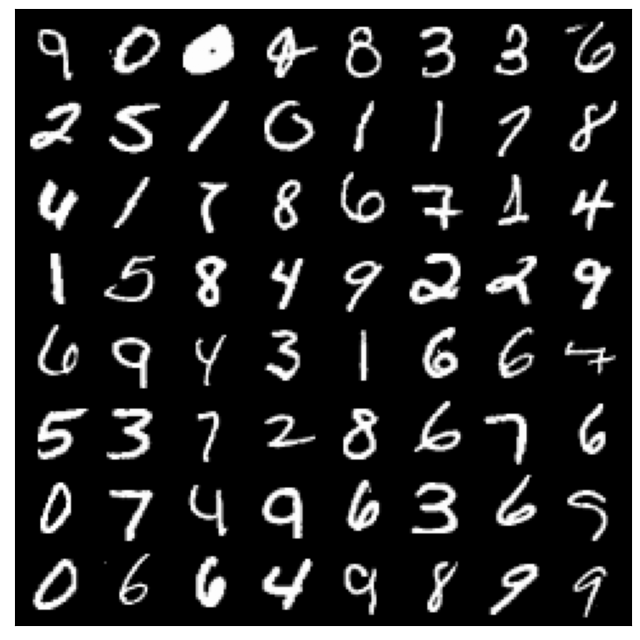

In [12]:
show_images(images)

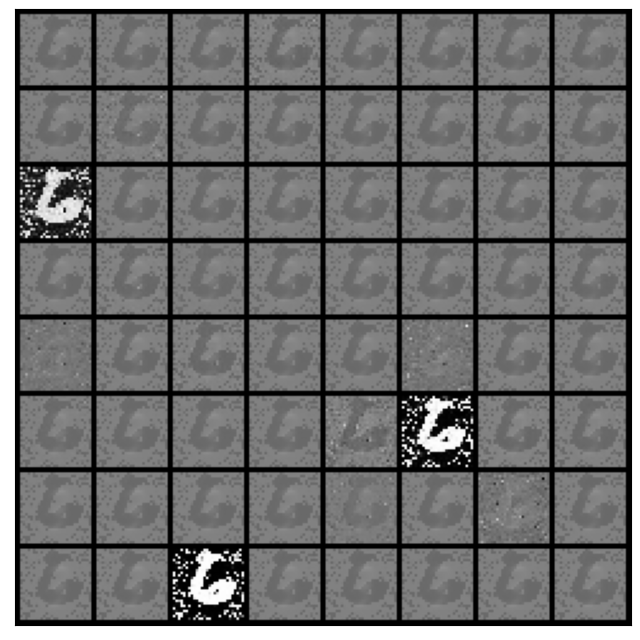

In [13]:
show_images(recon_images)

In [ ]:
my_dict = {
    "epochs": list_of_epochs, 
    "learning_rate": [LEARNING_RATE] * len(list_of_epochs)
}

df = pd.DataFrame(my_dict)